#A simple autoencoder test
Bottleneck consists of a single number, which determines the fraction of the image covered in black squares

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from matplotlib import pyplot as plt

import os

In [ ]:
# Decoder goes here
N_image = 64 # Size of (square) input image

def linear(x):
    # x represents the fraction of the image full of ones
    img = np.repeat(np.linspace(-1,1,N_image), N_image).reshape(N_image,N_image) * x
    return img

def ellipsoid(A,e,theta):
    B = A*(1.-e)
    x = np.tile(np.linspace(-1,1,N_image).reshape(1,N_image), (N_image,1))
    y = np.tile(-np.linspace(-1,1,N_image).reshape(N_image,1), (1,N_image))
    x_prime = x * np.cos(theta) - y * np.sin(theta)
    y_prime = x * np.sin(theta) + y * np.cos(theta)
    r_prime = np.sqrt((x_prime/A)**2 + (y_prime/B)**2)
    img = np.exp(-r_prime)
    return(img)

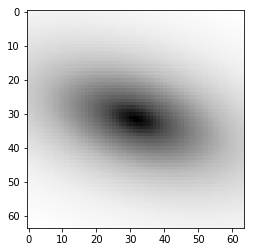

In [3]:
# And here's a test to see that the decoder does what we expect:
gal = ellipsoid(1.,0.5,0.3)
plt.imshow(gal, cmap="Greys")
plt.show()

#print gal

In [5]:
#Making dataset
N_train = 10000
noise = 0.05

A = np.random.uniform(0.1,0.5,size = N_train)
e = np.random.uniform(0.2,0.75,size = N_train)
theta = np.random.uniform(0.0,1.,size = N_train)*np.pi

train_images = np.array([ellipsoid(A[i],e[i],theta[i]) + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image) \
                for i in np.arange(N_train)])

#train_images = []
#train_labels = []
#for i in range(N_train):
#    A = np.random.uniform()
#    e = np.random.uniform()
#    theta = np.random.uniform()*np.pi
#    img = ellipsoid(A,e,theta) + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image)
#    train_images.append(img)

train_images = np.array([train_images]).reshape(N_train,N_image,N_image,1)
##train_images_transposed = np.array([img.transpose() for img in train_images])
##train_images = np.concatenate((train_images, train_images_transposed))
##train_images = train_images.reshape(2*N_train,N_image,N_image,1)

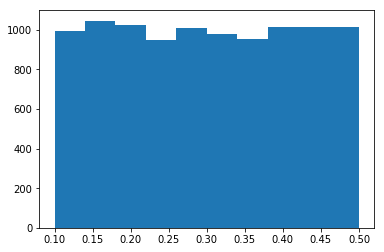

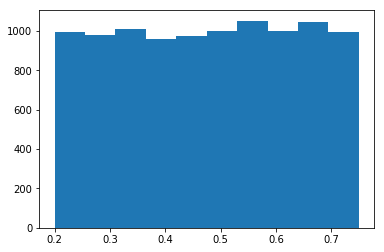

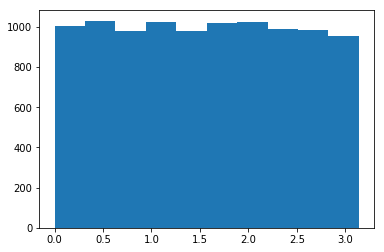

In [6]:
plt.hist(A); plt.show()
plt.hist(e); plt.show()
plt.hist(theta); plt.show()

In [7]:
print train_images.shape

(10000, 64, 64, 1)


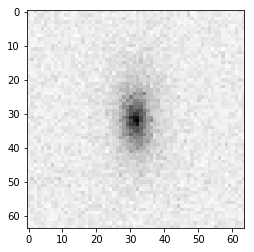

[0.06825469 0.2030076  0.13114075 0.18137553 0.15216479 0.18997339
 0.18316059 0.11101625 0.18614285 0.18688135 0.23099898 0.18056362
 0.24470608 0.18051466 0.247224   0.35336156 0.29052031 0.3876559
 0.34060706 0.47183226 0.36485863 0.40121536 0.49523352 0.50813437
 0.52397476 0.5868111  0.73179241 0.61791584 0.73064498 0.81692132
 0.84977031 0.93826414 0.94485985 0.87797587 0.81788513 0.86946597
 0.71284055 0.65124028 0.58932299 0.50837336 0.51386975 0.53879855
 0.49034179 0.24973736 0.38376175 0.3966669  0.30068243 0.24255524
 0.33567581 0.22788107 0.21149055 0.23325926 0.2585704  0.18882788
 0.17572011 0.2033977  0.15574801 0.12767252 0.17180677 0.16440913
 0.01897817 0.10259904 0.07553615 0.06502965]


In [8]:
# And here's a test to check that the training images are reasonable:
plt.imshow(train_images[10,:,:,0], cmap='Greys')
plt.show()
print train_images[4,int(N_image/2),:,0]

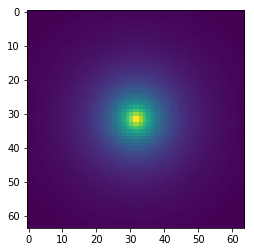

In [9]:
mean_image = np.mean(train_images,axis=0)[:,:,0]
plt.imshow(mean_image)
plt.show()

In [10]:
#Lambda Layer (Decoder, galaxies)
def ellipsoid_layer(X):
    A = tf.tile(tf.reshape(X[:,0], [tf.shape(X)[0],1,1,1]), [1,N_image,N_image,1])
    e = tf.tile(tf.reshape(X[:,1], [tf.shape(X)[0],1,1,1]), [1,N_image,N_image,1])
    theta = 3.14159265*tf.tile(tf.reshape(X[:,2], [tf.shape(X)[0],1,1,1]), [1,N_image,N_image,1])
    
    #Attempt at setting bounds on parameters
    #A = A*tf.math.sigmoid(10*A)
    #e = e*tf.math.sigmoid(10*e)
    #e = e*tf.math.sigmoid(10.*(1-e))
    #theta = theta*tf.math.sigmoid(10*theta)    
    
    # possible papers:
    #https://papers.nips.cc/paper/7942-constrained-generation-of-semantically-valid-graphs-via-regularizing-variational-autoencoders.pdf
    
    B = A * (1. - e)
    
    x = tf.tile(tf.reshape(tf.linspace(-1.,1.,N_image), [1,N_image,1]), [N_image,1,1])
    y = - tf.tile(tf.reshape(tf.linspace(-1.,1.,N_image), [N_image,1,1]), [1,N_image,1])
    
    x = tf.tile(tf.reshape(x,[1,N_image,N_image,1]), [tf.shape(X)[0],1,1,1])
    y = tf.tile(tf.reshape(y,[1,N_image,N_image,1]), [tf.shape(X)[0],1,1,1])
    
    x_prime = x * tf.math.cos(theta) - y * tf.math.sin(theta)
    y_prime = x * tf.math.sin(theta) + y * tf.math.cos(theta)
    r_prime = tf.math.sqrt((x_prime/A)**2 + (y_prime/B)**2)
    
    img = tf.math.exp(-r_prime)
    
    return img

    #img = tf.tile(tf.reshape(img, [1,N_image,N_image,1]), [tf.shape(x)[0],1,1,1])
    #img = tf.tile(tf.reshape(x, [tf.shape(x)[0],1,1,1]), [1,N_image,N_image,1]) * img

In [ ]:
#model = models.Sequential()
filt_size = 3
fs = filt_size
# Define layers (named, so we can nab them later)
inputs = layers.Input(shape=(N_image, N_image, 1))
conv1A = layers.Conv2D(16, (fs, fs), activation='relu', padding="same")(inputs)
conv1B = layers.Conv2D(16, (fs, fs), activation='relu', padding="same")(conv1A)
pool1 = layers.MaxPooling2D((2, 2)).apply(conv1B)
conv2A = layers.Conv2D(32, (fs, fs), activation='relu', padding="same")(pool1)
conv2B = layers.Conv2D(32, (fs, fs), activation='relu', padding="same")(conv2A)
pool2 = layers.MaxPooling2D((2, 2))(conv2B)
conv3A = layers.Conv2D(64, (fs, fs), activation='relu', padding="same")(pool2)
conv3B = layers.Conv2D(64, (fs, fs), activation='relu', padding="same")(conv3A)
pool3 = layers.MaxPooling2D((2, 2))(conv3B)
flatten1 = layers.Flatten()(pool3) 
dense1 = layers.Dense(64, activation='sigmoid')(flatten1)
dense2 = layers.Dense(32, activation='sigmoid')(dense1)
dense3 = layers.Dense(3,  activation='sigmoid')(dense2)

#model.add(layers.Dense(3136, activation='relu'))
#model.add(layers.Reshape((7, 7, 64)))

#model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
#model.add(layers.UpSampling2D((2, 2)))
#model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
#model.add(layers.UpSampling2D((2, 2)))
#model.add(layers.Conv2D(1, (fs, fs), activation='sigmoid', padding="same"))

#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(1))

lambda1 = layers.Lambda(lambda x:ellipsoid_layer(x))(dense3)
model    = models.Model(inputs, lambda1)
model_bn = models.Model(inputs, dense3)

model.summary()

In [ ]:
model.compile(optimizer='RMSprop',
              loss='mean_squared_logarithmic_error',
              metrics=['accuracy']
             )
#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

checkpoint_path = 'autoencoder_2_checkpoints/autoencoder_2.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
model.fit(train_images, train_images, epochs=5, callbacks=[cp_callback])
#model.fit(train_images, train_labels/10., epochs=5)

In [ ]:
testpar = 0.5,0.2,0.5
test_img = ellipsoid(*testpar).reshape(N_image,N_image,1)# + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image,1)
#test_img = test_img[:,:,0].transpose().reshape(28,28,1)
out = model.predict(np.array([test_img]))

In [ ]:
plt.imshow(test_img[:,:,0])
plt.show()
#print test_img[:,int(N_image/2),0]

In [ ]:
plt.imshow(out[0,:,:,0])
plt.show()
#print out[0,:,15,0]
print testpar, model_bn.predict(np.array([test_img]))
#print out

In [ ]:
# Look for distribution of results from the training sample
fitvals = model_bn.predict(train_images)
plt.hist(fitvals[:,0]); plt.show()
plt.hist(fitvals[:,1]); plt.show()
plt.hist(fitvals[:,2]); plt.show()

In [ ]:
plt.scatter(A,fitvals[:,0]); plt.ylabel("A",fontsize=18); plt.xlabel("$\hat{A}$",fontsize=18); plt.show()
plt.scatter(e,fitvals[:,0]); plt.ylabel("e",fontsize=18); plt.xlabel("$\hat{e}$",fontsize=18); plt.show()
plt.scatter(theta,fitvals[:,0]); plt.ylabel(r"$\theta$",fontsize=18); plt.xlabel(r"$\hat{\theta}$",fontsize=18); plt.show()

In [ ]:
w = model.get_weights()
warr = np.array(w)
print warr[6].shape

In [ ]:
#plt.imshow(warr[6],aspect='auto')
#plt.hist(warr[6].reshape(-1),bins=30)
print warr[1]

In [ ]:
# Run the following to see all the weights (filters) for one of the layers
#for i in np.arange(64):    
#    plt.imshow(w[2][:,:,0,i])
#    #plt.imshow(np.random.uniform(-1,1,9*9).reshape(9,9))
#    plt.show()

In [ ]:
#Lambda Layer (Decoder) (TL's copy):
def make_regions(x):
    x_int = x[1]
    print x, tf.to_float(x_int)
    img = np.zeros(N_image*N_image).reshape(N_image,N_image)
    Q = int(np.floor(x_int*N_image))
    img[:,0:Q] = 1
    return img

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.add(layers.Lambda(make_regions))

In [ ]:
model.summary()

In [ ]:
# Here's the mnist train data, for reference:

#mnist_data = np.load('mnist.npz')
#(train_images, train_labels), (test_images, test_labels) = (mnist_data['x_train'], mnist_data['y_train']), (mnist_data['x_test'], mnist_data['y_test'])

In [ ]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()


In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

In [ ]:
model.predict_classes(np.array([test_images[0]]))

In [ ]:
test_labels[0]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_images[0][:,:,0])